#### CIE-Project B || Group - 7

#### Imports

In [52]:
import os
import pandas as pd
import numpy as np
import scipy as sp
from scipy.signal import resample, find_peaks
import matplotlib.pyplot as plt
from scipy.io import loadmat

# from sklearn import preprocessing ##importing for normalization
# from sklearn.decomposition import PCA
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler, minmax_scale, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, LSTM, CuDNNLSTM
from keras.utils import np_utils

plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.frameon'] = True
%matplotlib widget

##### Get the root directory and change to it

In [53]:
rootdir = os.getcwd()
os.chdir(rootdir)

#### Variable Assignment

In [54]:
Training_Folder = 'EPOT_DATA'
Validation_Aug_Folder = 'Validation_augmented_data'
Experiment = 'Experiment'
Ex_Validation = 'Experimental_validation'

counter = 0

#### Parsing

##### Parse the training and validation-augmented data

In [55]:
# Initialize lists for training and validation
training_tr = []; training_tr_labels = []

validation_aug = []; validation_aug_labels = [] # validation augmented data

#------------------------------------------------------------------------------

for subdir, dirs, files in os.walk(rootdir):
    
    if Training_Folder.lower() in subdir.lower():
        for file in files:
            if file.endswith('.mat'):
                lbl = [file.split('_')[1], file.split('_')[2][:3]]
                lb = np.asarray(lbl, dtype=float)
                # load mat-file
                mat = loadmat(os.path.join(subdir, file))
                # get the numpy data from the mat file
                mat = mat['num_data']
                # append data to the list
                training_tr.append(mat)
                training_tr_labels.append(lb)

    elif Validation_Aug_Folder.lower() in subdir.lower():
        for file in files:
            if file.endswith('.mat'):
                lbl = [file.split('_')[1], file.split('_')[2][:3]]
                lb = np.asarray(lbl, dtype=float)
                # load mat-file
                mat = loadmat(os.path.join(subdir, file))
                # get the numpy data from the mat file
                mat = mat['num_data']
                # append data to the list
                validation_aug.append(mat)
                validation_aug_labels.append(lb)

##### Parse the experimental data

In [92]:
# Initialize lists for training and validation
ex_data = []; ex_labels = []

#------------------------------------------------------------------------------

for subdir, dirs, files in os.walk(rootdir):
    
    if Experiment.lower() in subdir.lower():
        for file in files:
            if file.endswith('.txt'):
                
                with open(os.path.join(subdir, file), 'r') as f:
                    x = pd.read_csv(os.path.join(subdir, file), delimiter='\t', decimal=',', skiprows=8, header=None)
                    x = np.asarray(x, dtype=float)
                    ex_data.append(x)
len(ex_data)
data=ex_data[1][:,0]
np.where(data==0.05)
ex_data[1][50000,0]
dc_1=ex_data[0][50000:50050,1]
dc_2=ex_data[0][50000:50050,2]
dc_3=ex_data[0][50000:50050,3]
dc_4=ex_data[0][50000:50050,4]
dc=[dc_1,dc_2]
dc

[array([-0.0330091,  0.739658 ,  1.64999  ,  2.58666  ,  3.38099  ,
         3.91132  ,  4.11866  ,  3.99566  ,  3.51999  ,  2.71266  ,
         1.61532  ,  0.310658 , -1.10301  , -2.52968  , -3.90234  ,
        -5.15834  , -6.23601  , -7.08934  , -7.71734  , -8.11901  ,
        -8.30068  , -8.27668  , -8.09301  , -7.77801  , -7.34734  ,
        -6.82101  , -6.23001  , -5.58901  , -4.89601  , -4.15201  ,
        -3.38334  , -2.59668  , -1.79701  , -0.999342 , -0.217342 ,
         0.534991 ,  1.25466  ,  1.92966  ,  2.56066  ,  3.15132  ,
         3.70532  ,  4.21599  ,  4.68966  ,  5.12099  ,  5.51566  ,
         5.86266  ,  6.16232  ,  6.41599  ,  6.61799  ,  6.76932  ]),
 array([ 2.70862 ,  2.19895 ,  1.33662 ,  0.160953, -1.25205 , -2.77105 ,
        -4.25605 , -5.60871 , -6.74671 , -7.59838 , -8.12605 , -8.34305 ,
        -8.27671 , -7.95538 , -7.41438 , -6.70538 , -5.84905 , -4.86305 ,
        -3.81138 , -2.74471 , -1.67538 , -0.61838 ,  0.396953,  1.35429 ,
         2.24995 ,  3.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
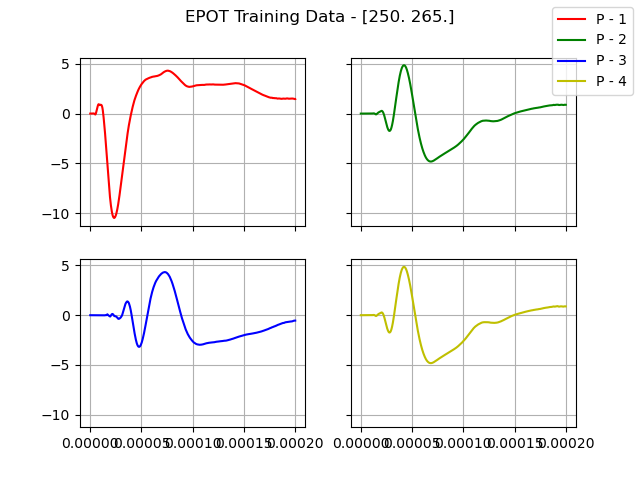

In [59]:
plt.close()
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

l = 3

fig.suptitle(f'EPOT Training Data - {training_tr_labels[l]}')

axs[0,0].plot(training_tr[l][:,0], training_tr[l][:,1], label='P - 1', c = 'r')
axs[0,1].plot(training_tr[l][:,0], training_tr[l][:,2], label='P - 2', c = 'g')
axs[1,0].plot(training_tr[l][:,0], training_tr[l][:,3], label='P - 3', c = 'b')
axs[1,1].plot(training_tr[l][:,0], training_tr[l][:,4], label='P - 4', c = 'y')

fig.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
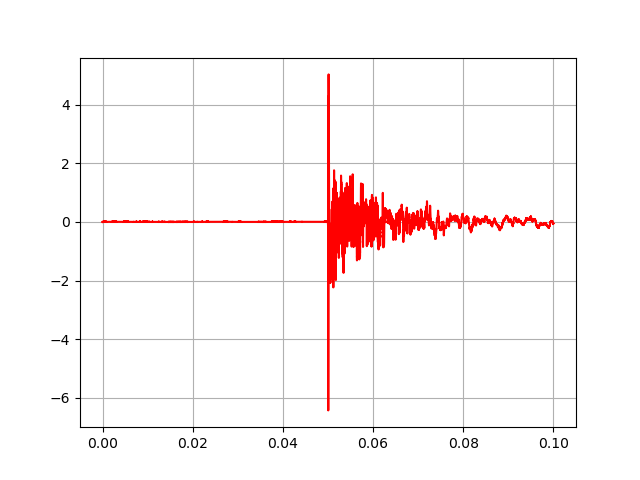

In [117]:
plt.close()
l = 1
plt.plot(ex_data[l][:,0], ex_data[l][:,1], label='P - 1', c = 'r')
plt.show()


### Cutting Experimental Data

In [118]:
ex_Cdata=[]
d_c=[]
for i in range(0,len(ex_data)):
    data=ex_data[i][:,0]
    start=np.where(data==0.05)
    end=np.where(data==0.0502)
    d_0=ex_data[i][start[0][0]:end[0][0],0]
    d_1=ex_data[i][start[0][0]:end[0][0],1]
    d_2=ex_data[i][start[0][0]:end[0][0],2]
    d_3=ex_data[i][start[0][0]:end[0][0],3]
    d_4=ex_data[i][start[0][0]:end[0][0],4]
    d_c=[d_0,d_1,d_2,d_3,d_4]
    ex_Cdata.append(d_c)
len(ex_Cdata)
ex_Cdata[1][1]


array([-2.97366e-02,  3.93003e-03,  4.32634e-02,  2.02634e-02,
       -4.77366e-02, -1.07737e-01, -1.18403e-01, -7.04033e-02,
        3.09300e-02,  1.69597e-01,  3.26263e-01,  4.72597e-01,
        5.68597e-01,  5.73263e-01,  4.62263e-01,  2.15263e-01,
       -1.55070e-01, -6.03737e-01, -1.06940e+00, -1.49940e+00,
       -1.84607e+00, -2.06207e+00, -2.08974e+00, -1.90474e+00,
       -1.50907e+00, -9.34737e-01, -2.24403e-01,  5.55597e-01,
        1.34426e+00,  2.09826e+00,  2.77460e+00,  3.33993e+00,
        3.77326e+00,  4.06993e+00,  4.23426e+00,  4.27293e+00,
        4.19660e+00,  4.01826e+00,  3.76093e+00,  3.43626e+00,
        3.04660e+00,  2.59193e+00,  2.07993e+00,  1.51226e+00,
        8.88930e-01,  2.22263e-01, -4.70070e-01, -1.17840e+00,
       -1.88974e+00, -2.57874e+00, -3.22907e+00, -3.83107e+00,
       -4.37207e+00, -4.84874e+00, -5.25307e+00, -5.59574e+00,
       -5.86774e+00, -6.07840e+00, -6.23207e+00, -6.34007e+00,
       -6.40307e+00, -6.43107e+00, -6.42674e+00, -6.399

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
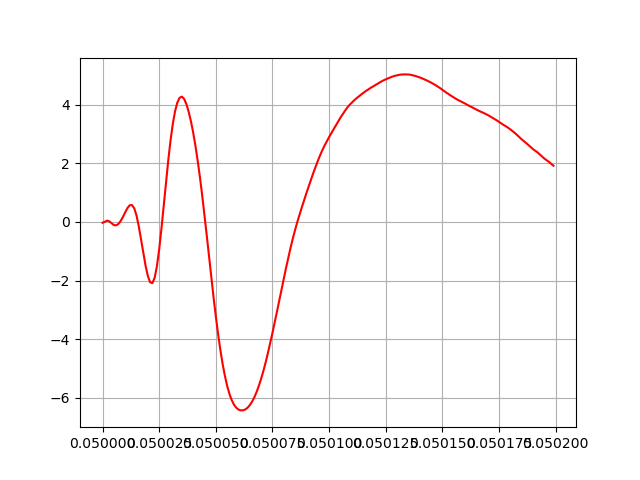

In [119]:
plt.close()
l = 1
plt.plot(ex_Cdata[l][0], ex_Cdata[l][1], label='P - 1', c = 'r')
plt.show()


In [ ]:
# Create arrays for Cut data
for x in gaitpos:
    for y in smartphone:
        # variables of Cut data
        globals()['gyrCut%s_s%s' % (x, y)] = []
        globals()['accCut%s_s%s' % (x, y)] = []
##---------------------------------------------------------------------------------------------------------------------

for j in gaitpos:
    for i in smartphone:
            # variables of raw the data
            gyrl = eval(f'gyr{j}_s{i}')
            accl = eval(f'acc{j}_s{i}')
            
            # variables of filtered the data
            gyrF = eval(f'gyrFiltered{j}_s{i}')
            accF = eval(f'accFiltered{j}_s{i}')

            # variables of cutted the data
            gyrC = eval(f'gyrCut{j}_s{i}')
            accC = eval(f'accCut{j}_s{i}')

            # getting the shape of the gyroscope and accelerometer data
            n = len(gyrF)

            # Filter all the data
            for r in range(0, n):
                
                tCut = np.asarray(gyrl[r].iloc[:,0])
                freqCut = np.round(len(tCut)/(tCut[-1]))
                # print(f'accFiltered{j}_s{i} - {[r]}')
                gf, aF = cutData(gyrF[r], accF[r], freqCut)

                gyrC.append(gf)
                accC.append(aF)

##### Parse the experimental validation data

In [ ]:
# Initialize lists for training and validation
ex_val_data = []; ex_val_labels = []

#------------------------------------------------------------------------------

for subdir, dirs, files in os.walk(rootdir):
    
    if Ex_Validation.lower() in subdir.lower():
        for file in files:
            if file.endswith('.txt'):
                
                with open(os.path.join(subdir, file), 'r') as f:
                    # print(file.split('_')[2], file.split('_')[3], file.split('_')[5][:3])
                    lbl = [file.split('_')[2], file.split('_')[3], file.split('_')[5][:3]]
                    lb = np.asarray(lbl, dtype=float)

                    x = pd.read_csv(os.path.join(subdir, file), delimiter='\t', decimal=',', skiprows=8, header=None)
                    x = np.asarray(x, dtype=float)
                    ex_val_data.append(x)
                    ex_val_labels.append(lb)

#### Augmentation

##### Variable initialization

In [ ]:
## -----------------------------------------------------------------------------
#Assuming P1 on top and counter clockwise order
## -----------------------------------------------------------------------------


# Variables for the augmented data
training_tl = np.zeros_like(np.asarray(training_tr)); training_tl_labels = np.zeros_like(np.asarray(training_tr_labels))
training_bl = np.zeros_like(np.asarray(training_tr)); training_bl_labels = np.zeros_like(np.asarray(training_tr_labels))
training_br = np.zeros_like(np.asarray(training_tr)); training_br_labels = np.zeros_like(np.asarray(training_tr_labels))

##### Top-Left

In [ ]:
for i in range (0, len(training_tr)):
        training_tl[i][:,0] = training_tr[i][:,0]
        training_tl[i][:,1] = training_tr[i][:,1]
        training_tl[i][:,2] = training_tr[i][:,4]
        training_tl[i][:,3] = training_tr[i][:,3]
        training_tl[i][:,4] = training_tr[i][:,2]

for i in range (0, len(training_tl_labels)):
    training_tl_labels[i][0] = 500 - training_tr_labels[i][0]
    training_tl_labels[i][1] = training_tr_labels[i][1]

##### Bottom-Left

In [ ]:
for i in range (0, len(training_bl)):
    if i in np.where(np.asanyarray(training_tl_labels) == 250.)[0]:
        training_bl[i][:,0] = training_tl[i][:,0]
        training_bl[i][:,1] = training_tl[i][:,1]
        training_bl[i][:,2] = training_tl[i][:,2]
        training_bl[i][:,3] = training_tl[i][:,3]
        training_bl[i][:,4] = training_tl[i][:,4]
    else:
        training_bl[i][:,0] = training_tl[i][:,0]
        training_bl[i][:,1] = training_tl[i][:,3]
        training_bl[i][:,2] = training_tl[i][:,2]
        training_bl[i][:,3] = training_tl[i][:,1]
        training_bl[i][:,4] = training_tl[i][:,4]

for i in range (0, len(training_bl_labels)):
    training_bl_labels[i][0] = 500. - training_tr_labels[i][0]
    training_bl_labels[i][1] = 500. - training_tr_labels[i][1]

##### Bottom-Right

In [ ]:
for i in range (0, len(training_br)):
        training_br[i][:,0] = training_bl[i][:,0]
        training_br[i][:,1] = training_bl[i][:,1]
        training_br[i][:,2] = training_bl[i][:,4]
        training_br[i][:,3] = training_bl[i][:,3]
        training_br[i][:,4] = training_bl[i][:,2]

for i in range (0, len(training_br_labels)):
    training_br_labels[i][0] = training_tr_labels[i][0]
    training_br_labels[i][1] = 500 - training_tr_labels[i][1]

##### Delete overlapping data points

In [ ]:
training_tl = np.delete(np.asarray(training_tl), np.where(np.asanyarray(training_tl_labels) == 250.)[0], axis = 0)
training_tl_labels = np.delete(np.asarray(training_tl_labels), np.where(np.asanyarray(training_tl_labels) == 250.)[0], axis = 0)

training_bl = np.delete(np.asarray(training_bl), 0, axis = 0)
training_bl_labels = np.delete(np.asarray(training_bl_labels), 0, axis = 0)

training_br = np.delete(np.asarray(training_br), np.where(np.asanyarray(training_br_labels) == 250.)[0], axis = 0)
training_br_labels = np.delete(np.asarray(training_br_labels), np.where(np.asanyarray(training_br_labels) == 250.)[0], axis = 0)

##### Makesure the augmentation is done on all quadrants

In [ ]:
print(f'{np.asarray(training_tl).shape} \t{np.asarray(training_tr).shape} \n{np.asarray(training_bl).shape} \t{np.asarray(training_br).shape} \n{counter}')

(219, 20000, 5) 	(244, 20000, 5) 
(243, 20000, 5) 	(219, 20000, 5) 
0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
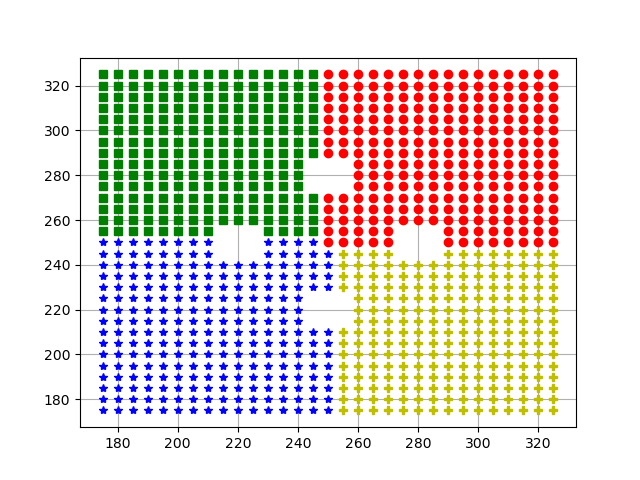

In [ ]:
plt.close()
for i in range(0, len(training_tr_labels)):
    plt.plot(training_tr_labels[i][0], training_tr_labels[i][1], 'o', c = 'r')
for j in range (0, len(training_tl_labels)):
    plt.plot(training_tl_labels[j][0], training_tl_labels[j][1], 's', c = 'g')
    plt.plot(training_br_labels[j][0], training_br_labels[j][1], 'P', c = 'y')
for k in range (0, len(training_bl_labels)):
    plt.plot(training_bl_labels[k][0], training_bl_labels[k][1], '*', c = 'b')            

plt.show()

#### Concatenate and normalize

In [ ]:
training = np.concatenate((training_tr, training_tl, training_bl, training_br), axis = 0)
training_labels = np.concatenate((training_tr_labels, training_tl_labels, training_bl_labels, training_br_labels), axis = 0)

print(f'Shape of all training set: {training.shape} \nShape of all training labels: {training_labels.shape}')

Shape of all training set: (925, 20000, 5) 
Shape of all training labels: (925, 2)


##### check with the validation augmented data

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
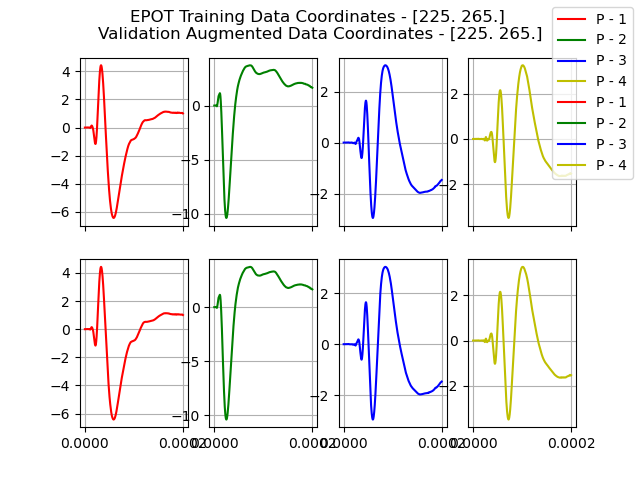

In [ ]:
plt.close()
fig, axs = plt.subplots(2, 4, sharex=True)

val_c = 1 # Given validation folder has 4 data points. so use - (0, 1, 2, 3)

# find out the index of the validation set in the training data
x = []
for i in range (0, len(training_labels)):
    if (training_labels[i][0] == validation_aug_labels[val_c][0]) and (training_labels[i][1] == validation_aug_labels[val_c][1]):
        x.append(i)

# plot to compare the validation set with the training set
fig.suptitle(f'EPOT Training Data Coordinates - {training_labels[x[0]]} \nValidation Augmented Data Coordinates - {validation_aug_labels[val_c]}')

axs[0,0].plot(training[x[0]][:,0], training[x[0]][:,1], label='P - 1', c = 'r')
axs[0,1].plot(training[x[0]][:,0], training[x[0]][:,2], label='P - 2', c = 'g')
axs[0,2].plot(training[x[0]][:,0], training[x[0]][:,3], label='P - 3', c = 'b')
axs[0,3].plot(training[x[0]][:,0], training[x[0]][:,4], label='P - 4', c = 'y')

axs[1,0].plot(validation_aug[val_c][:,0], validation_aug[val_c][:,1], label='P - 1', c = 'r')
axs[1,1].plot(validation_aug[val_c][:,0], validation_aug[val_c][:,2], label='P - 2', c = 'g')
axs[1,2].plot(validation_aug[val_c][:,0], validation_aug[val_c][:,3], label='P - 3', c = 'b')
axs[1,3].plot(validation_aug[val_c][:,0], validation_aug[val_c][:,4], label='P - 4', c = 'y')

# check if the data is exactly the same
for i in range (1, 5):
    if np.all(training[x[0]][:,i] == validation_aug[val_c][:,i], axis = 0):
        print('Data is augmented correctly')

fig.legend()
plt.show()

In [ ]:
diff = training[x[0]][:,1] - validation_aug[val_c][:,1]
diff

array([0.     , 0.     , 0.     , ..., 0.00011, 0.00012, 0.00012])

##### Normalize

In [ ]:
for i in range (0, len(training)):
    for j in range (1, 5):
        training[i][:,j] = minmax_scale(training[i][:,j])

In [ ]:
scalar = MinMaxScaler()
scalar.fit(training_labels)
training_labels = scalar.transform(training_labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
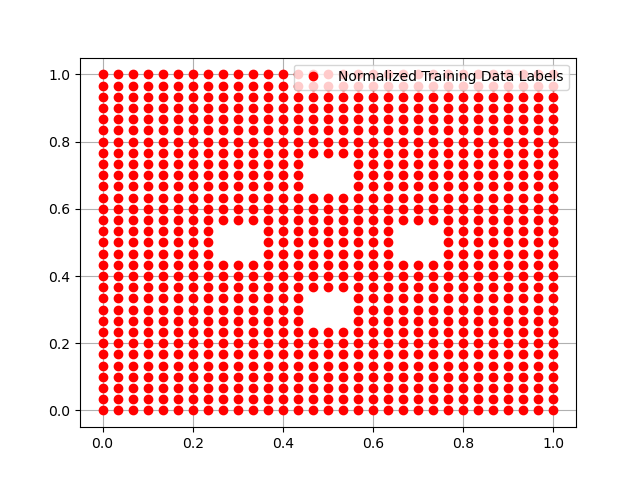

In [ ]:
plt.close()
plt.plot(training_labels[:,0], training_labels[:,1], 'o', c = 'r', label = 'Normalized Training Data Labels')
plt.legend()
plt.show()

In [ ]:
train_resample = []
for i in range (0, len(training)):
    train_resample.append(pd.DataFrame(training[i], columns = ['time', '1', '2', '3', '4']))
    # drop the time column
    train_resample[i] = train_resample[i].drop(columns = ['time'])

size = 100

for i in range (0, len(training)):
    train_resample[i] = resample(train_resample[i], size)

np.asarray(train_resample).shape


TypeError: 'int' object is not callable

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
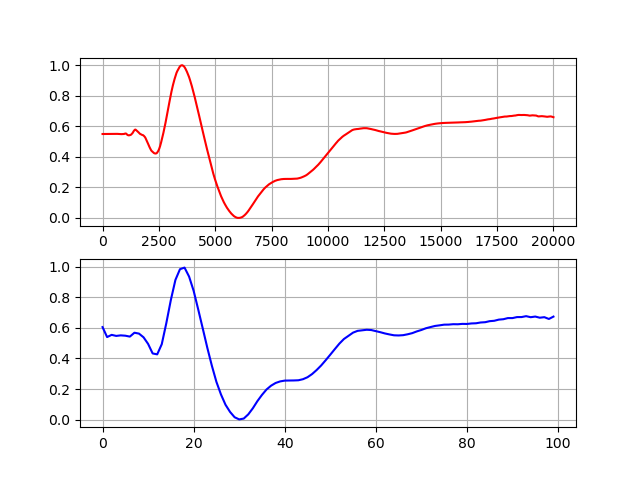

In [ ]:
plt.close()
fig, axs = plt.subplots(2, 1, sharey=True)

axs[0].plot(training[0][:,1], c = 'r')
axs[1].plot(train_resample[0][:,1], c = 'b')
plt.show()

## SVM

In [ ]:
#Import scikit-learn dataset library
from sklearn import datasets

#Load dataset
size = 0.2

x_train, x_test, y_train, y_test = train_test_split(train_resample, training_labels, shuffle=True, test_size=size)
#np.asarray(
print(f'Shape of training data - {len(x_train)} \tShape of its labels - {len(y_train)} \nShape of testing data - {len(x_test)} \tShape of its labels - {len(y_test)}')


Shape of training data - 740 	Shape of its labels - 740 
Shape of testing data - 185 	Shape of its labels - 185


In [ ]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(x_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(x_test)

ValueError: Found array with dim 3. Estimator expected <= 2.

In [ ]:
#Evaluating the code
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

#### AI Model

In [ ]:
size = 0.2

x_train, x_test, y_train, y_test = train_test_split(np.asarray(train_resample), training_labels, shuffle=True, test_size=size)

print(f'Shape of training data - {x_train.shape} \tShape of its labels - {y_train.shape} \nShape of testing data - {x_test.shape} \tShape of its labels - {y_test.shape}')

Shape of training data - (740, 100, 4) 	Shape of its labels - (740, 2) 
Shape of testing data - (185, 100, 4) 	Shape of its labels - (185, 2)


##### Model Initialization

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(100,4)))
model.add(Dense(units=250, activation='relu'))
model.add(Dense(units=50, activation='relu'))
# model.add(Dense(units=30, activation='relu'))
model.add(Dense(units=2, kernel_initializer='normal'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 250)               100250    
                                                                 
 dense_1 (Dense)             (None, 50)                12550     
                                                                 
 dense_2 (Dense)             (None, 2)                 102       
                                                                 
Total params: 112,902
Trainable params: 112,902
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile model
opt = tf.keras.optimizers.Adam(lr=0.001)

model.compile(loss = 'mse', optimizer = opt, metrics=['mse', 'mae', 'Accuracy'])

# Fit the model
history = model.fit(x_train, y_train, epochs=40, verbose=1, shuffle=True)

# evaluate the model
pred = model.evaluate(x_test, y_test)

D:\lectures\sem3\cie\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/40
24/24 [==============================] - 2s 5ms/step - loss: 0.1322 - mse: 0.1322 - mae: 0.3004 - Accuracy: 0.4986
Epoch 2/40
24/24 [==============================] - 0s 6ms/step - loss: 0.0941 - mse: 0.0941 - mae: 0.2648 - Accuracy: 0.5284
Epoch 3/40
24/24 [==============================] - 0s 6ms/step - loss: 0.0890 - mse: 0.0890 - mae: 0.2590 - Accuracy: 0.5324
Epoch 4/40
24/24 [==============================] - 0s 6ms/step - loss: 0.0851 - mse: 0.0851 - mae: 0.2517 - Accuracy: 0.6081
Epoch 5/40
24/24 [==============================] - 0s 6ms/step - loss: 0.0796 - mse: 0.0796 - mae: 0.2439 - Accuracy: 0.6176
Epoch 6/40
24/24 [==============================] - 0s 5ms/step - loss: 0.0727 - mse: 0.0727 - mae: 0.2314 - Accuracy: 0.6784
Epoch 7/40
24/24 [==============================] - 0s 6ms/step - loss: 0.0637 - mse: 0.0637 - mae: 0.2127 - Accuracy: 0.7135
Epoch 8/40
24/24 [==============================] - 0s 5ms/step - loss: 0.0534 - mse: 0.0534 - mae: 0.1897 - Accuracy:

dict_keys(['loss', 'mse', 'mae', 'Accuracy'])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
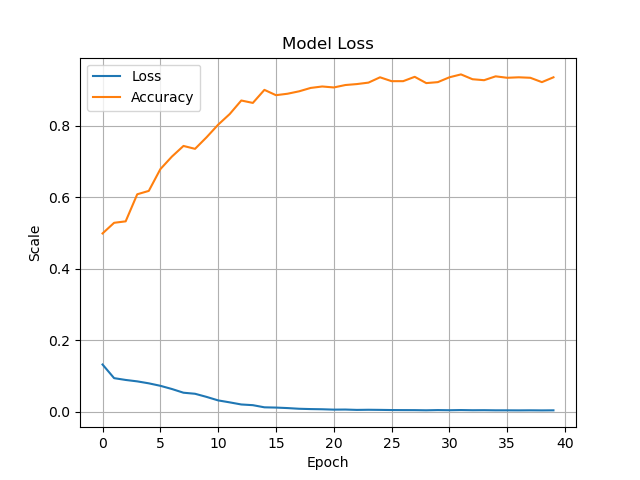

In [ ]:
print(history.history.keys())
# "Loss"
plt.close()
plt.plot(history.history['loss'])
plt.plot(history.history['Accuracy'])
plt.title('Model Loss')
plt.ylabel('Scale')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Accuracy'], loc='upper left')
plt.show()

#### Predict for experimental data validation

In [ ]:
freq = 1/(ex_val_data[0][:,0][1] - ex_val_data[0][:,0][0]) 
# freq = np.round(len(ex_val_data[0][:,0])/(ex_val_data[0][:,0][-1]))
peaks, _ = find_peaks(ex_val_data[0][:,1], height = 1) # , distance = freq*0.0001
peaks2, _ = find_peaks(ex_val_data[0][:,2], height = 1)
peaks3, _ = find_peaks(ex_val_data[0][:,3], height = 1)
print(peaks, peaks2, peaks3)

IndexError: list index out of range

IndexError: list index out of range

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
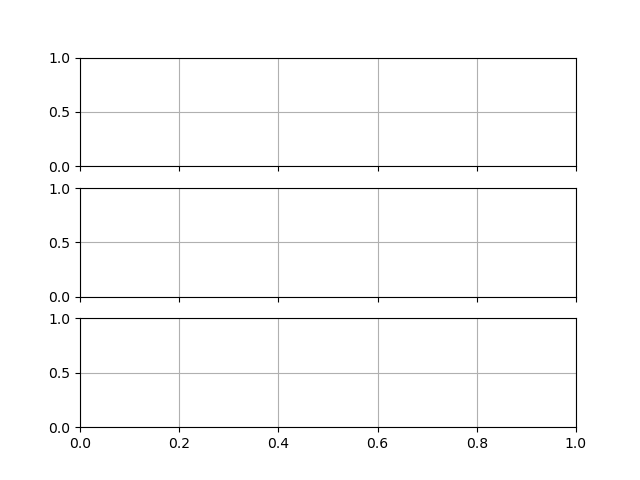

In [ ]:
plt.close()
fig, axs = plt.subplots(3, 1, sharex = True, sharey=True)

axs[0].plot(ex_val_data[0][:,1], c = 'r', label = f'Experimental Validation Data {ex_val_labels[0]}')
axs[0].plot(peaks, ex_val_data[0][:,1][peaks], 'x', label = 'Peaks', c = 'b')

axs[1].plot(ex_val_data[0][:,2], c = 'g', label = f'Experimental Validation Data {ex_val_labels[1]}')
axs[1].plot(peaks2, ex_val_data[0][:,2][peaks2], 'x', label = 'Peaks', c = 'b')

axs[2].plot(ex_val_data[0][:,3], c = 'y', label = f'Experimental Validation Data {ex_val_labels[2]}')
axs[2].plot(peaks3, ex_val_data[0][:,3][peaks3], 'x', label = 'Peaks', c = 'b')

plt.show()

In [ ]:
check = ex_val_data[0][:,1][peaks[1]:peaks[3]]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
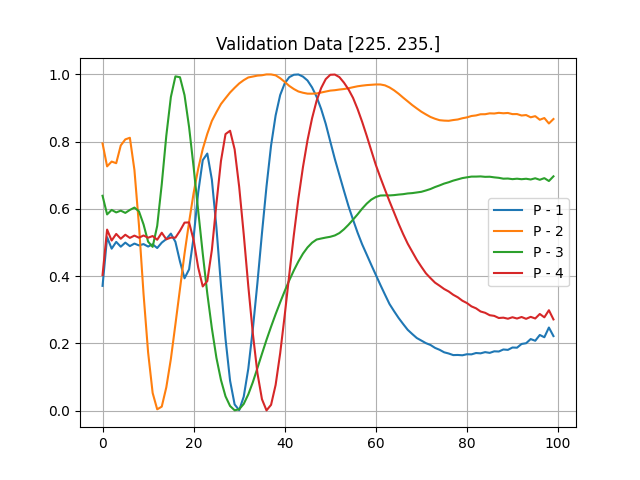

In [ ]:
c = []
checking1 = validation_aug[0][:,1:5]
checking1 = minmax_scale(checking1)
checking1 = resample(checking1, 100)

checking2 = validation_aug[1][:,1:5]
checking2 = minmax_scale(checking2)
checking2 = resample(checking2, 100)

c.append(checking1)
c.append(checking2)

plt.close()
plt.title(f'Validation Data {validation_aug_labels[0]}')
plt.plot(checking1[:,0], label = 'P - 1')
plt.plot(checking1[:,1], label = 'P - 2')
plt.plot(checking1[:,2], label = 'P - 3')
plt.plot(checking1[:,3], label = 'P - 4')
plt.legend()
plt.show()

In [ ]:
print(f'{validation_aug_labels[0]} \n{validation_aug_labels[1]}')

p = model.predict(np.asarray(c))
# print(p)
p = scalar.inverse_transform(p)
print(p)

print(f'Difference between the actual and predicted coordinates: \n{validation_aug_labels[0][0]-p[0][0]} {validation_aug_labels[0][1]-p[0][1]}\n {validation_aug_labels[1][0]-p[1][0]} {validation_aug_labels[1][1]-p[1][1]}')

[225. 235.] 
[225. 265.]
[[219.03642 236.61855]
 [216.9375  271.48615]]
Difference between the actual and predicted coordinates: 
5.9635772705078125 -1.6185455322265625
 8.0625 -6.48614501953125


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
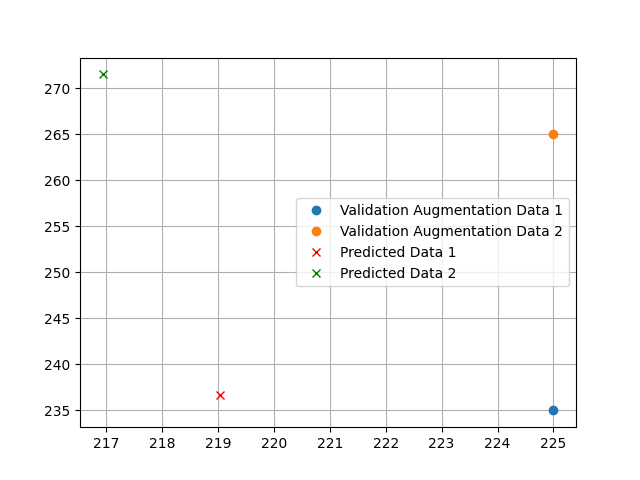

In [ ]:
plt.close()
plt.plot(validation_aug_labels[0][0], validation_aug_labels[0][1], 'o' , label = 'Validation Augmentation Data 1')
plt.plot(validation_aug_labels[1][0], validation_aug_labels[1][1], 'o' , label = 'Validation Augmentation Data 2')

plt.plot(p[0][0], p[0][1], 'x' , c = 'r' , label = 'Predicted Data 1')
plt.plot(p[1][0], p[1][1], 'x' , c = 'g' , label = 'Predicted Data 2')

plt.legend()
plt.show()